<a href="https://colab.research.google.com/github/kei-mo/TheoriticalNeuroscience/blob/master/Chapter8_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 9 : Classical Conditioning and Reinforcement Learning

In [0]:
from matplotlib import pyplot as plt
import numpy as np

## 9.1 Classical conditioning

### Prediction rewards: The Recorla-Wagner Rule

$v =wu$  
$w←w+\epsilon \delta u $  
$\delta = r - u $

#### Acquire

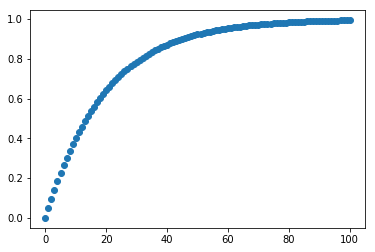

In [23]:
epsilon = 0.05
w_list = [0]
for i in range(100):
    r = 1
    u = 1
    v = w_list[i]*u
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)
plt.plot(w_list, "o")
plt.show()

#### Extinction

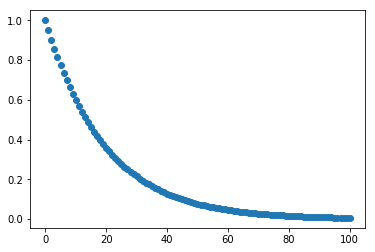

In [24]:
epsilon = 0.05
w_list = [1]
for i in range(100):
    u = 1 
    r = 0
    v = w_list[i]*u
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)
plt.plot(w_list,"o")
plt.show()

#### Partial reinforcment

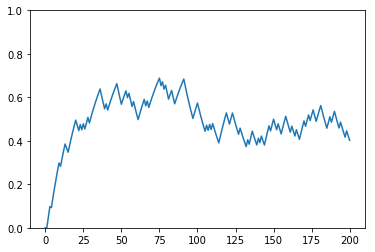

In [27]:
epsilon = 0.05
w_list = [0]
for i in range(200):
    u = 1 
    r = 1 if np.random.rand()>0.5 else 0
    v = w_list[i]*u
    delta = r - v
    w = w_list[i] + epsilon * delta * u
    w_list.append(w)
plt.plot(w_list)
plt.ylim(0,1)
plt.show()

### Temporal difference 

## 9.3 Static Action Choice

### Indirect actor

### Direct actor